In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

In [41]:
def normalize_df(df):
    string_col = df.iloc[:, 0]
    numeric_data = df.iloc[:, 1:]

    scaler = MinMaxScaler()
    normalized_values = scaler.fit_transform(numeric_data.values)

    normalized_df = pd.DataFrame(normalized_values, columns = numeric_data.columns)
    final_df = pd.concat([string_col, normalized_df], axis=1)

    # print(final_df.head(5))

    return final_df, scaler
    

In [11]:
def preprocess_with_19_quarters(file_path, seq_len=16, pred_len=3):
    df = pd.read_csv(file_path)
    class_col = df.columns[0]
    revenue_cols = df.columns[1:]
    classes = sorted(df[class_col].unique())


    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    num_classes = len(classes)

    X_list = []
    y_list = []

    df, scaler = normalize_df(df)


    for _, row in df.iterrows():
        class_name = row[class_col]
        class_idx = class_to_idx[class_name]
        #print(class_idx)
        class_onehot = np.eye(num_classes)[class_idx]

        series = row[1:].values.astype(float)


        series = series.reshape(-1, 1).flatten()

        if len(series) < seq_len + pred_len:
            continue

        for i in range(len(series) - seq_len - pred_len + 1):
            x_seq = series[i:i+seq_len].reshape(seq_len, 1)
            y_seq = series[i+seq_len:i+seq_len+pred_len]

            class_feats = np.tile(class_onehot, (seq_len, 1)) 
            # print(class_feats.shape)
            # class_idx = np.array([[class_idx], [1]])
            # class_idx = class_idx.reshape(-1, 1)
            # print(x_seq.shape)
            # print(class_idx)
            x_combined = np.concatenate([x_seq, class_feats], axis=1)

            X_list.append(x_combined)
            y_list.append(y_seq)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.float32)

    return X_tensor, y_tensor, scaler

In [12]:
class RevenueDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_size, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.gru = nn.GRU(input_dim, hidden_size, num_layers, batch_first=True)


    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)

        out, _ = self.lstm(x, (h0, c0))
        # out, _ = self.gru(x)

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [43]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, save_path):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0

        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)
        training_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                output = model(x)
                loss = criterion(output, y)
                val_loss += loss.item() * x.size(0)
        
        val_loss /= len(val_loader.dataset)
        validation_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    torch.save(model.state_dict(), save_path)
    return training_losses, validation_losses
        

In [44]:
def inverse_transform_preds_targets(y_pred, y_true, scaler):
    y_pred_np = y_pred.detach().cpu().numpy()
    y_true_np = y_true.detach().cpu().numpy()

    sub_scaler = MinMaxScaler()
    sub_scaler.min_ = scaler.min_[-3:]
    sub_scaler.scale_ = scaler.scale_[-3:]
    sub_scaler.data_min_ = scaler.data_min_[-3:]
    sub_scaler.data_max_ = scaler.data_max_[-3:]
    sub_scaler.data_range_ = scaler.data_range_[-3:]
    sub_scaler.n_features_in_ = 3

    y_pred_orig = sub_scaler.inverse_transform(y_pred_np)
    y_true_orig = sub_scaler.inverse_transform(y_true_np)

    return y_pred_orig, y_true_orig

In [62]:
def test_model(model, test_loader, criterion, scaler):
    model.eval()
    test_loss = 0.0
    mae_sum = 0.0
    num_samples = 0.0
    mse_sum = 0.0
    original_revenues = []
    predicted_revenues = []

    with torch.no_grad():
        for X, y in test_loader:
            outputs = model(X)
            #print(X)
            #print(outputs)
            loss = criterion(outputs, y)
            test_loss += loss.item() * X.size(0)
            #print(f"y: {y}")
            #print(f"Scaler {scaler}")
            y_pred_orig, y_orig = inverse_transform_preds_targets(outputs, y, scaler)
            original_revenues.append(y_orig[-1, 0])
            predicted_revenues.append(y_pred_orig[-1, 0])
            mae = np.mean(np.abs(y_pred_orig - y_orig))
            mse = np.mean((y_pred_orig - y_orig)**2)

            mae_sum += mae * y.shape[0]
            mse_sum += mse * y.shape[0]
            num_samples += y.shape[0]
            

    test_loss /= len(test_loader.dataset)
    mae_loss = mae_sum / num_samples
    mse_loss = mse_sum / num_samples
    print(f"Normalized MSE Test Loss: {test_loss:.4f}")
    print(f"MAE Test Loss: {mae_loss:.4f}")
    print(f"MSE Test Loss: {mse_loss:.4f}")

    return original_revenues, predicted_revenues

In [99]:
file_path = "C:\\Users\\a1247244\\Downloads\\Innovation_Day\\lstmdata.csv"
save_path = "C:\\Users\\a1247244\\Downloads\\Innovation_Day\\model_weights.pth"
X, y, scaler = preprocess_with_19_quarters(file_path)
print("X shape:", X.shape) 
print("y shape:", y.shape)

dataset = RevenueDataset(X, y)

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = int(test_ratio * total_size) + 1

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

model = LSTMModel(18, 64, 3, 3, 0)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_list, val_list = train_model(model, train_loader, val_loader, 10, criterion, optimizer, save_path)

og_revenues, pred_revenues = test_model(model, test_loader, criterion, scaler)

X shape: torch.Size([1425, 16, 18])
y shape: torch.Size([1425, 3])
Epoch 1/10 | Train Loss: 0.0105 | Val Loss: 0.0103
Epoch 2/10 | Train Loss: 0.0096 | Val Loss: 0.0100
Epoch 3/10 | Train Loss: 0.0079 | Val Loss: 0.0060
Epoch 4/10 | Train Loss: 0.0065 | Val Loss: 0.0063
Epoch 5/10 | Train Loss: 0.0060 | Val Loss: 0.0058
Epoch 6/10 | Train Loss: 0.0046 | Val Loss: 0.0042
Epoch 7/10 | Train Loss: 0.0053 | Val Loss: 0.0035
Epoch 8/10 | Train Loss: 0.0046 | Val Loss: 0.0034
Epoch 9/10 | Train Loss: 0.0042 | Val Loss: 0.0033
Epoch 10/10 | Train Loss: 0.0043 | Val Loss: 0.0037
Normalized MSE Test Loss: 0.0020
MAE Test Loss: 5802.3384
MSE Test Loss: 107344042.0699


In [100]:
import matplotlib.pyplot as plt

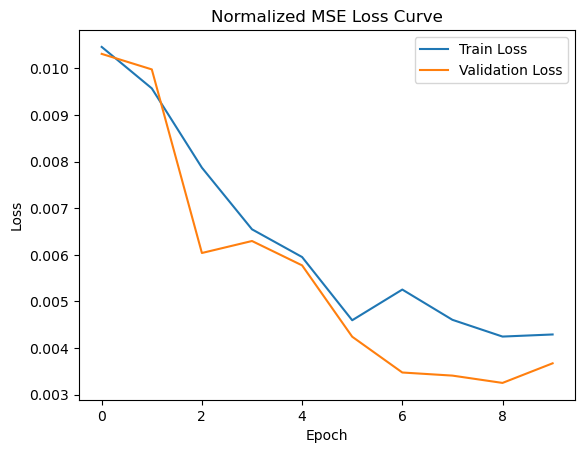

In [101]:
plt.plot(train_list, label = 'Train Loss')
plt.plot(val_list, label = 'Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Normalized MSE Loss Curve')
plt.show()

[]

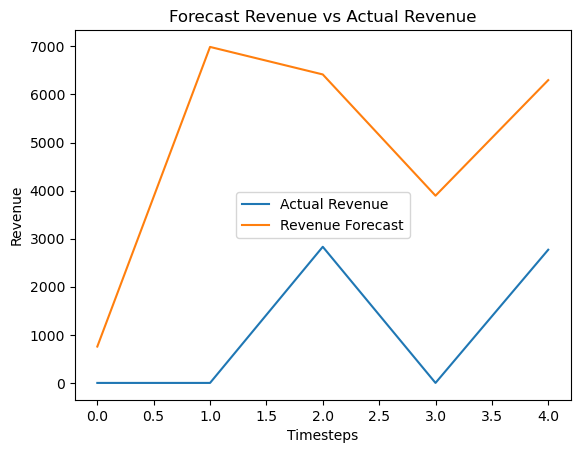

In [102]:
plt.plot(og_revenues, label = "Actual Revenue")
plt.plot(pred_revenues, label = "Revenue Forecast")
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Revenue')
plt.title('Forecast Revenue vs Actual Revenue')
plt.plot()